In [95]:
import pandas as pd  
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import numpy as np
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

In [6]:
sol_data = pd.read_csv("delaney.csv")
sol_data.head() #shows first 5 rows


,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [18]:
sol_data.SMILES[0] # shows 1st element of the column "SMILES"

'ClCC(Cl)(Cl)Cl'

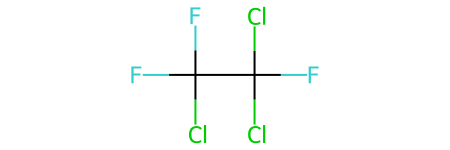

In [28]:
mol_object = Chem.MolFromSmiles(sol_data.SMILES[4]) #creates RDKit molecule object from SMILES
mol_object


In [16]:
mol_object.GetNumAtoms()  #gives the number of atoms in a molecule

8

In [22]:
mol_objects_list = []
for element in sol_data.SMILES:  # creates list of RDKit molecule objects from "SIMILES" column of the data frame
    temp_obj = Chem.MolFromSmiles(element)
    if temp_obj is None : continue # just in case for errors in SMILES strings
    mol_objects_list.append(temp_obj)
if (len(mol_objects_list) == len(sol_data.SMILES)): # checking for errors
    print("No errors")

No errors


# # Calculating descriptors of molecules

In [45]:
def generate_descriptors(mol_objects): #generates molecular descriptors for model building
    
    baseData = np.empty([1])
    i=0  
    for mol in mol_objects:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames) # constructes DataFrame from numpy ndarray
    
    return descriptors #returns Pandas DataFrame
molecule_descriptors = generate_descriptors(mol_objects_list)
molecule_descriptors.head()

,MolLogP,MolWt,NumRotatableBonds
0,2.5954,167.850,0.0
1,2.3765,133.405,0.0
2,2.5938,167.850,1.0
3,2.0289,133.405,1.0
4,2.9189,187.375,1.0


In [59]:
def AromaticAtoms(mol): # works out number of aromatic atoms in the molecule RDKit object
  # list comprehension below gives boolean values for aromaticity of each atom in the molecule
    aromatic_atoms = [mol.GetAtomWithIdx(i).GetIsAromatic() for i in range(mol.GetNumAtoms())] 
    aa_count = []
    for i in aromatic_atoms:
        if i==True:
            aa_count.append(1)
    sum_aa_count = sum(aa_count)
    return sum_aa_count 

desc_AromaticAtoms = [AromaticAtoms(mol) for mol in mol_objects_list] # list of number of aromatic atoms in each molecule
desc_HeavyAtoms = [Descriptors.HeavyAtomCount(mol) for mol in mol_objects_list] #list of heavy atoms in each molecule
desc_AromaticProportion = [int(a) / int(b) for a,b in zip(desc_AromaticAtoms,desc_HeavyAtoms)]# aromatic proportion descriptor


In [70]:
molecule_descriptors["AromPropor"] =  desc_AromaticProportion # complete set of descriptors for the model (fetures for machine learning)
molecule_descriptors.head()

,MolLogP,MolWt,NumRotatableBonds,AromPropor
0,2.5954,167.850,0.0,0.0
1,2.3765,133.405,0.0,0.0
2,2.5938,167.850,1.0,0.0
3,2.0289,133.405,1.0,0.0
4,2.9189,187.375,1.0,0.0


In [62]:
target_val_of_solubility = sol_data.iloc[:,1] # the measured solubility values (targets/labels for machine learning)
target_val_of_solubility.head()

0   -2.18
1   -2.00
2   -1.74
3   -1.48
4   -3.04
Name: measured log(solubility:mol/L), dtype: float64

## Preparing  the training and testing datasets (80/20)

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(molecule_descriptors,target_val_of_solubility \
, test_size=0.2) # splits data into training and testing datasets


## Linear regression model + Training

In [85]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)


LinearRegression()

In [86]:
Y_pred_train = model.predict(X_train)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.74983209 -0.0067034   0.01313151 -0.44296566]
Intercept: 0.2829655149805288
Mean squared error (MSE): 0.97
Coefficient of determination (R^2): 0.78


## Validation of the model on the testing dataset

In [87]:
Y_pred_test = model.predict(X_test)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.74983209 -0.0067034   0.01313151 -0.44296566]
Intercept: 0.2829655149805288
Mean squared error (MSE): 1.17
Coefficient of determination (R^2): 0.71


## Visualizing results

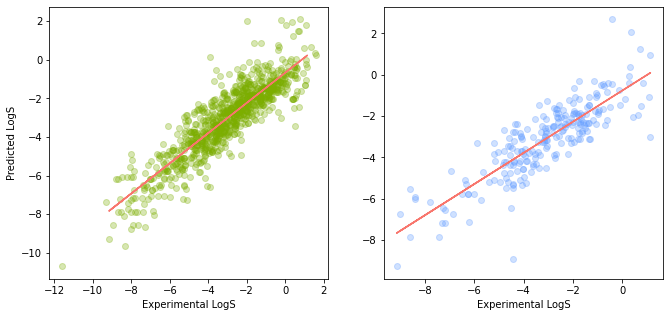

In [96]:
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')
plt.title('The training data set')
# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

plt.savefig('plot_horizontal_logS.png')
plt.savefig('plot_horizontal_logS.pdf')
plt.title('The testing data set')
plt.show()